In [ ]:
import numpy as np
from numpy.linalg import inv
import math
import itertools
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

In [ ]:
#load train data as numpy array
X_train = np.genfromtxt('/Users/Amiros/GitHub/Machine Learning for Data Science/hw3/data/gaussian_process/X_train.csv',delimiter=',')
y_train = np.genfromtxt('/Users/Amiros/GitHub/Machine Learning for Data Science/hw3/data/gaussian_process/y_train.csv',delimiter=',')

#load test data as numpy array
X_test = np.genfromtxt('/Users/Amiros/GitHub/Machine Learning for Data Science/hw3/data/gaussian_process/X_test.csv',delimiter=',')
y_test = np.genfromtxt('/Users/Amiros/GitHub/Machine Learning for Data Science/hw3/data/gaussian_process/y_test.csv',delimiter=',')

## 1-A

In [ ]:
# kernel matrix restricted points in Training data
def K_restricted(X_train, b):
    k = np.linalg.norm(X_train[None,:,:]-X_train[:,None,:],axis=2)
    return np.exp(-1/b * k)

def G_process(X_train, y_train, X_test, b, sigma):
    K_n = K_restricted(X_train, b)
    
    I = np.identity(X_train.shape[0])
    c = np.linalg.inv((sigma) * I + K_n)
    
    m = []
    v = []
    for i in range(X_test.shape[0]):
    # Calculate mean
        distance = np.sqrt(np.sum((X_test[i] - X_train) ** 2, axis=1))
        G_Kernel = np.hstack(np.exp((-1/b) * distance).reshape(1,-1))
        w = np.dot(G_Kernel, c)
        a = np.dot(w, y_train)
        m.append(a)

    return m

## 1-B

In [ ]:
b_list=[5,7,9,11,13,15]
sigma_list=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
c = list(itertools.product(b_list, sigma_list))

y_predict = []
for i in range(len(c)):
    y_predict.append(G_process(X_train, y_train, X_test, c[i][0], c[i][1]))
y_predict = np.array(y_predict)

In [ ]:
y_predict

In [ ]:
def RMSE(y_predict, y_test, c):
    rmse = []
    
    for i in range(len(c)):
        a = math.sqrt(np.sum((y_predict[i] - y_test)**2) / 42)
        rmse.append(a)  
    return  rmse

In [ ]:
rmse = RMSE(y_predict, y_test, c)
rmse_table = pd.DataFrame(
    {'parameters': c, 'rmse_value': rmse})
rmse_table

## 1-C

In [ ]:
rmse_table.min()

The best solution is for b= 5 and sigma = 0.1 with rmse value of 1.93031.

This approach comapring to homework 1 gives lower rmse, therefore more accurate result.

## 1-D

In [ ]:
# aa = X_train[:,3]
# bb = X_test[:,3]

# 2

In [3]:
#load train data as numpy array
X_train0 = np.genfromtxt('/Users/Amiros/GitHub/Machine Learning for Data Science/hw3/data/boosting/X_train.csv',delimiter=',')
y_train = np.genfromtxt('/Users/Amiros/GitHub/Machine Learning for Data Science/hw3/data/boosting/y_train.csv',delimiter=',')

#load test data as numpy array
X_test0 = np.genfromtxt('/Users/Amiros/GitHub/Machine Learning for Data Science/hw3/data/boosting/X_test.csv',delimiter=',')
y_test = np.genfromtxt('/Users/Amiros/GitHub/Machine Learning for Data Science/hw3/data/boosting/y_test.csv',delimiter=',')

time: 33.4 ms


In [4]:
X_train = np.hstack((X_train0, np.ones((1036,1), dtype=np.int)))
X_test = np.hstack((X_test0, np.ones((1000,1), dtype=np.int)))

time: 2.83 ms


In [28]:
# Least Square classification
def LS(X_train, y_train):
    coef = np.linalg.inv(np.dot(X_train.T, X_train)).dot(X_train.T).dot(y_train)
    return coef



# Boosting algorithm
def AdaBoost(X_train, y_train, T):

    # create an index lsit with the size of training data
    index = np.full((X_train.shape[0]), range(0,X_train.shape[0]))

    # initial value
    w = np.full((X_train.shape[0]), 1/X_train.shape[0])    
    B_table = []
    epsilon_list = []
    alpha_list = []
    coef_array = np.empty((0, 6))
    
    for i in range(T):

        # choose random from the index according to the w distribution
        B_index = index[np.random.choice(index.shape[0], index.shape[0], replace=True, p= w)]
        B_table.append(B_index.tolist())

        # bootstrap samples
        B_X = X_train[B_index]
        B_y = y_train[B_index]

        # predict
        coef = LS(B_X, B_y)
        y_pred = np.sign(X_train.dot(coef))
        coef_array = np.append(coef_array, [coef], axis=0)

        # updating weights 
        epsilon = np.multiply((y_train != y_pred), w).sum()
        alpha = 0.5 * np.log((1 - epsilon)/epsilon)
        
        epsilon_list.append(epsilon)
        alpha_list.append(alpha)

        w_est = np.multiply(w, np.exp(-alpha * np.multiply(y_train, y_pred)))
        w = w_est/ w_est.sum()
    return coef_array, B_table, alpha_list, epsilon_list



# function to calculate error for every T
def error(X, y, coef, alpha, T):
    a = np.empty((0,0))
    final = np.empty((X.shape[0], 0))
    error_table = []
    
    for i in range(T):
        a = alpha[i] * np.sign(X.dot(coef[i]))
        final = np.append (final, a.reshape(-1,1), axis = 1)

        pred = np.sign(np.sum(final, axis =1))
        error = (pred != y).sum()/10
        error_table.append(error)

    return error_table

time: 78.3 ms


In [29]:
# running boosting algorithm
coef_array, B_table, alpha_list, epsilon_list = AdaBoost(X_train, y_train, 1500)

# # calculating training and testing error
# test_error = error(X_test, y_test, coef_array, alpha_list, 1500)
# train_error = error(X_train, y_train, coef_array, alpha_list, 1500)

time: 790 ms


 ## 2 - A

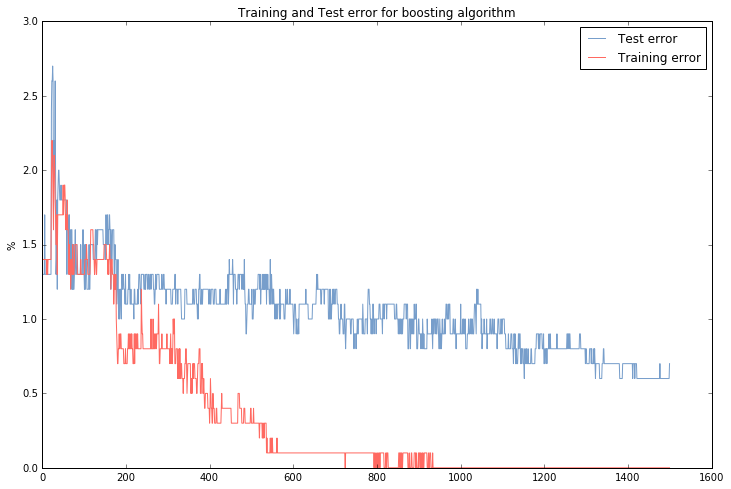

time: 493 ms


In [40]:
plt.figure(figsize=(12,8))

plt.plot(test_error, '#779ECB', train_error, '#FF6961')
plt.title('Training and Test error for boosting algorithm')
plt.ylabel('%')
labels = ['Test error', 'Training error']
plt.legend(labels)

## 2-B

time: 65.9 ms


## 2-C

In [13]:
flattened_B = [val for sublist in B_table for val in sublist]

time: 76 ms


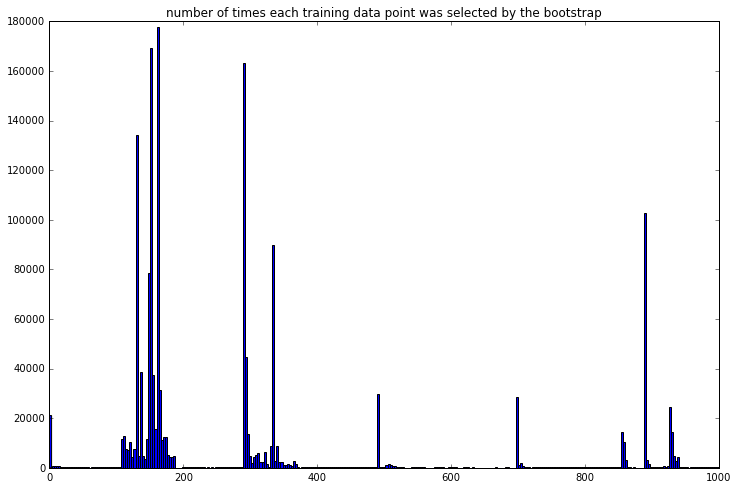

time: 1.93 s


In [17]:
plt.figure(figsize=(12,8))

plt.hist(flattened_B, bins='auto')
plt.xlim(-.05,1000.05)
plt.title('number of times each training data point was selected by the bootstrap')

## 2-D

(0, 1)

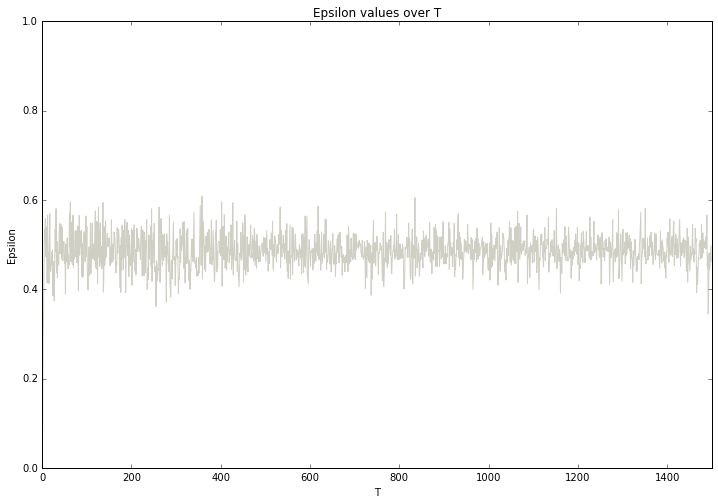

time: 401 ms


In [39]:
plt.figure(figsize=(12,8))

plt.plot(epsilon_list, '#CFCFC4')
plt.title('Epsilon values over T')
plt.ylabel('Epsilon')
plt.xlabel('T')
plt.xlim(-0.05, 1500.05)
plt.ylim(0, 1)

(-1, 1)

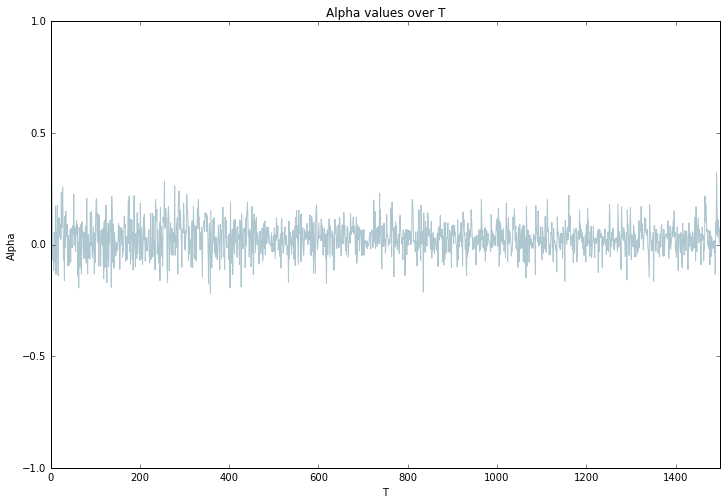

time: 416 ms


In [38]:
plt.figure(figsize=(12,8))

plt.plot(alpha_list, '#AEC6CF')
plt.title('Alpha values over T')
plt.ylabel('Alpha')
plt.xlabel('T')
plt.xlim(-0.05, 1500.05)
plt.ylim(-1, 1)